# Predicting Medical Appointment No-Shows
Data from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments/home)

In [2]:
# Imports
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

## Preprocessing

In [3]:
# Import the data
raw_data = pd.read_csv("KaggleV2-May-2016.csv")
print("Rows: {}\nColumns: {}".format(raw_data.shape[0], raw_data.shape[1]))

# Clean up column names
raw_data.columns = ["patient_id", "appointment_id", "gender", "scheduled_day",
                   "appointment_day", "age", "neighborhood", "scholarship",
                    "hypertension", "diabetes", "alcoholism", "handicap", "sms_received",
                   "no_show"]
raw_data.head()

Rows: 110527
Columns: 14


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Get data details
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
neighborhood       110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
# Check for missing values
raw_data.isnull().sum()

patient_id         0
appointment_id     0
gender             0
scheduled_day      0
appointment_day    0
age                0
neighborhood       0
scholarship        0
hypertension       0
diabetes           0
alcoholism         0
handicap           0
sms_received       0
no_show            0
dtype: int64

In [6]:
# Check for duplicates using the appointment unique identifier column
raw_data.duplicated("appointment_id").sum()

0

In [7]:
# Drop unneeded columns
raw_data.drop(["patient_id", "appointment_id"], axis=1, inplace=True)

# Convert scheduled_day and appointment_day to datetime format
raw_data["scheduled_day"] = pd.to_datetime(raw_data["scheduled_day"])
raw_data["appointment_day"] = pd.to_datetime(raw_data["appointment_day"])

# Convert qualitative columns to category type
def convert_to_category(df, cols):
    for col in cols:
        df[col] = df[col].astype("category")

convert_to_category(raw_data, ["gender", "neighborhood", "scholarship", "hypertension",
                              "diabetes", "alcoholism", "handicap", "sms_received", "no_show"])
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
gender             110527 non-null category
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
neighborhood       110527 non-null category
scholarship        110527 non-null category
hypertension       110527 non-null category
diabetes           110527 non-null category
alcoholism         110527 non-null category
handicap           110527 non-null category
sms_received       110527 non-null category
no_show            110527 non-null category
dtypes: category(9), datetime64[ns](2), int64(1)
memory usage: 3.5 MB


In [8]:
# Helper function to find unique column values
def unique_col_values(df):
    max_name_len = np.max([len(col_name) for col_name in raw_data.columns]) + 2
    format_str = "{:<" + str(max_name_len) + "}{:<8}{:<15}"

    print(format_str.format("Name", "Unique", "DType"))
    print()
    for col in df:
        print(format_str.format(df[col].name, len(df[col].unique()), str(df[col].dtype)))

unique_col_values(raw_data)

Name             Unique  DType          

gender           2       category       
scheduled_day    103549  datetime64[ns] 
appointment_day  27      datetime64[ns] 
age              104     int64          
neighborhood     81      category       
scholarship      2       category       
hypertension     2       category       
diabetes         2       category       
alcoholism       2       category       
handicap         5       category       
sms_received     2       category       
no_show          2       category       


### Univariate exploration

#### Categorical variables (more or less)

In [49]:
# Helper functions
def cat_explore(data, var, palette="ocean", l=6, w=4):
    print("##### {} #####\n".format(str(var)))
    fig = plt.figure(figsize=(l, w))
    sns.countplot(x=var, data=data, palette=palette)
    plt.title("Countplot: {}".format(var))
    plt.show()

    print("### Describe ###")
    print(raw_data[var].describe())
    print("\n### Value counts ###")
    print(raw_data[var].value_counts())
    print()

##### gender #####



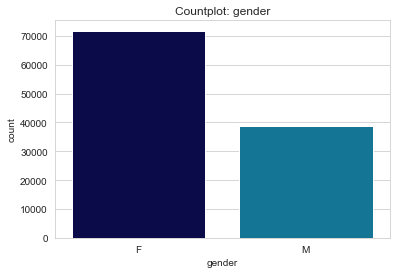

### Describe ###
count     110522
unique         2
top            F
freq       71837
Name: gender, dtype: object

### Value counts ###
F    71837
M    38685
Name: gender, dtype: int64

##### scholarship #####



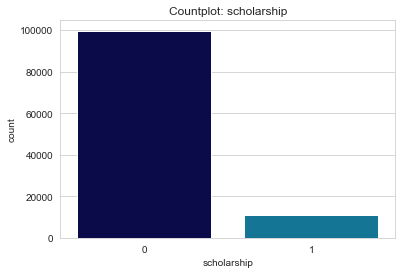

### Describe ###
count     110522
unique         2
top            0
freq       99661
Name: scholarship, dtype: int64

### Value counts ###
0    99661
1    10861
Name: scholarship, dtype: int64

##### hypertension #####



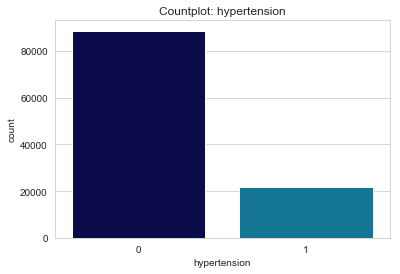

### Describe ###
count     110522
unique         2
top            0
freq       88721
Name: hypertension, dtype: int64

### Value counts ###
0    88721
1    21801
Name: hypertension, dtype: int64

##### diabetes #####



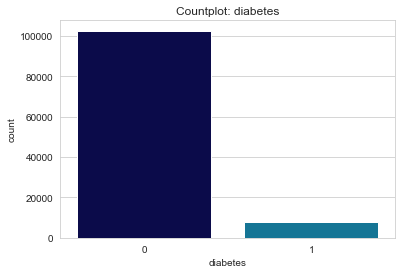

### Describe ###
count     110522
unique         2
top            0
freq      102579
Name: diabetes, dtype: int64

### Value counts ###
0    102579
1      7943
Name: diabetes, dtype: int64

##### alcoholism #####



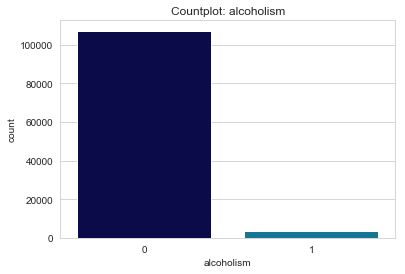

### Describe ###
count     110522
unique         2
top            0
freq      107162
Name: alcoholism, dtype: int64

### Value counts ###
0    107162
1      3360
Name: alcoholism, dtype: int64

##### handicap #####



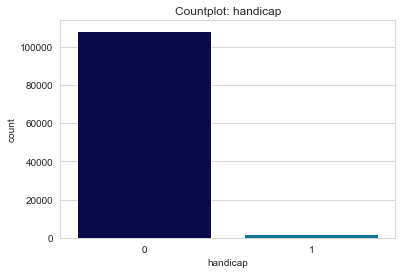

### Describe ###
count     110522
unique         2
top            0
freq      108283
Name: handicap, dtype: int64

### Value counts ###
0    108283
1      2239
Name: handicap, dtype: int64

##### sms_received #####



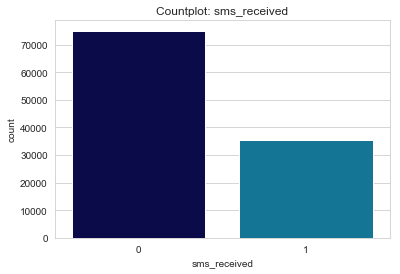

### Describe ###
count     110522
unique         2
top            0
freq       75040
Name: sms_received, dtype: int64

### Value counts ###
0    75040
1    35482
Name: sms_received, dtype: int64

##### no_show #####



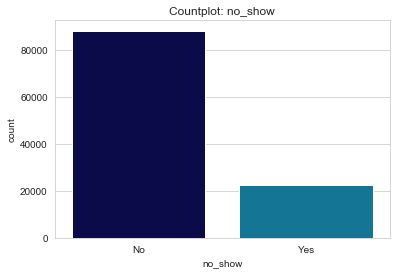

### Describe ###
count     110522
unique         2
top           No
freq       88208
Name: no_show, dtype: object

### Value counts ###
No     88208
Yes    22314
Name: no_show, dtype: int64



In [50]:
# List categorical variables excluding those with a larger number of unique values:
# scheduled_day, appointment_day, and neighborhood
cat_vars = ["gender", "scholarship", "hypertension", "diabetes",
            "alcoholism", "handicap", "sms_received", "no_show"]

# Run cat_explore function for categorical variables in cat_vars list
for var in cat_vars:
    cat_explore(data=raw_data, var=var)

##### handicap #####



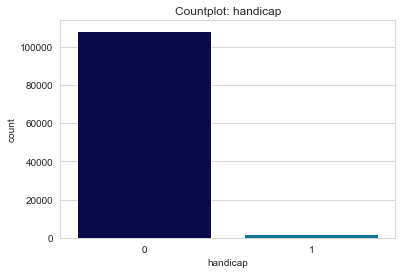

### Describe ###
count     110522
unique         2
top            0
freq      108283
Name: handicap, dtype: int64

### Value counts ###
0    108283
1      2239
Name: handicap, dtype: int64



In [44]:
# Convert the handicap variable to a binary 0, 1 (no, yes)
raw_data["handicap"] = raw_data["handicap"].apply(lambda x: 0 if x == 0 else 1).astype("category")
cat_explore(data=raw_data, var="handicap")

#### Scheduled-day  and appointment-day

In [30]:
print("##### scheduled_day #####")
print(raw_data["scheduled_day"].describe())
print("\n##### appointment_day #####")
print(raw_data["appointment_day"].describe())

##### scheduled_day #####
count                  110527
unique                 103549
top       2016-05-06 07:09:54
freq                       24
first     2015-11-10 07:13:56
last      2016-06-08 20:07:23
Name: scheduled_day, dtype: object

##### appointment_day #####
count                  110527
unique                     27
top       2016-06-06 00:00:00
freq                     4692
first     2016-04-29 00:00:00
last      2016-06-08 00:00:00
Name: appointment_day, dtype: object


In [31]:
# Create new feature that represents the elapsed time (in days) between
# making a medical appointment and the appointment itself

def calc_time_between(cols):
    appointment_day = cols[0]
    scheduled_day = cols[1]
    return (appointment_day.date() - scheduled_day.date()).days

raw_data["scheduled_to_appointment"] = raw_data[["appointment_day", "scheduled_day"]].apply(calc_time_between, axis=1)

print("##### scheduled_to_appointment #####")
raw_data["scheduled_to_appointment"].describe()

##### scheduled_to_appointment #####


count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: scheduled_to_appointment, dtype: float64

In [33]:
# Count the number of appointments less than zero
print("Number of scheduled_to_appointment less than zero: {}".format(len(raw_data[raw_data["scheduled_to_appointment"] < 0])))

Number of scheduled_to_appointment less than zero: 5


In [36]:
# Since there are only five, drop observations with scheduled_to_appointment < 0
raw_data = raw_data[raw_data["scheduled_to_appointment"] >= 0]
print("##### scheduled_to_appointment #####")
print(raw_data["scheduled_to_appointment"].describe())

##### scheduled_to_appointment #####
count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: scheduled_to_appointment, dtype: float64


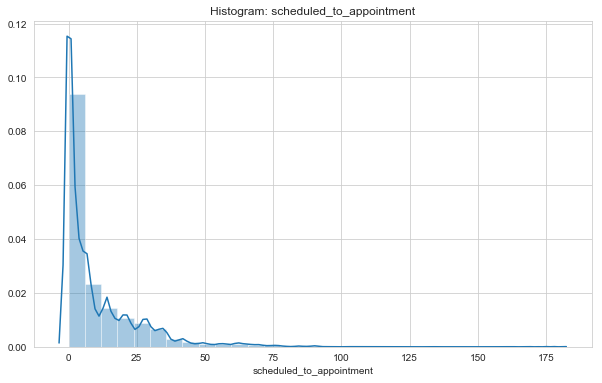

In [38]:
fig = plt.figure(figsize=(10, 6))
sns.distplot(raw_data["scheduled_to_appointment"], bins=30)
plt.title("Histogram: scheduled_to_appointment")
plt.show()

##### appointment_weekday #####



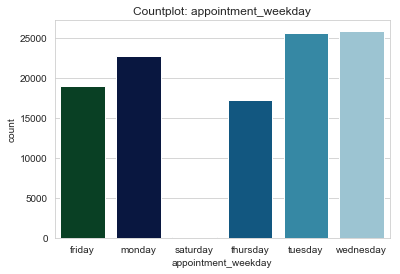

### Describe ###
count        110522
unique            6
top       wednesday
freq          25866
Name: appointment_weekday, dtype: object

### Value counts ###
wednesday    25866
tuesday      25638
monday       22714
friday       19019
thursday     17246
saturday        39
Name: appointment_weekday, dtype: int64



In [39]:
# Create new feature for the day of the week any given appointment occured on
def get_weekday(date):
    weekday_codes = {0: "monday", 1: "tuesday",
                    2: "wednesday", 3: "thursday",
                    4: "friday", 5: "saturday",
                    6: "sunday"}
    return weekday_codes[date.weekday()]

raw_data["appointment_weekday"] = raw_data["appointment_day"].apply(lambda x: get_weekday(x)).astype("category")
cat_explore(data=raw_data, var="appointment_weekday")

#### Neighborhood

##### Neighborhood #####



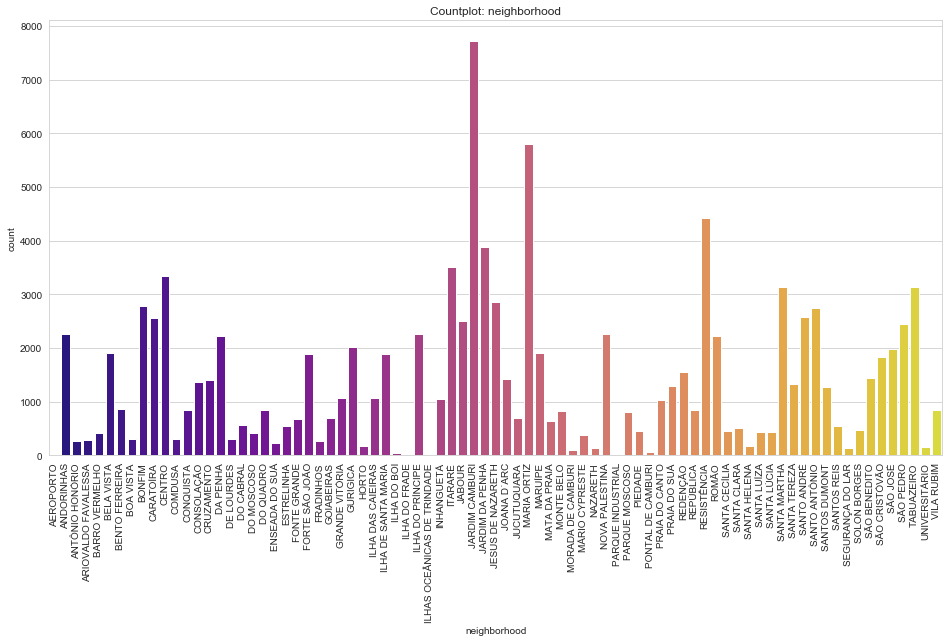

### Describe ###
count             110522
unique                81
top       JARDIM CAMBURI
freq                7717
Name: neighborhood, dtype: object

### Value counts ###
JARDIM CAMBURI       7717
MARIA ORTIZ          5805
RESISTÊNCIA          4430
JARDIM DA PENHA      3877
ITARARÉ              3514
CENTRO               3334
TABUAZEIRO           3131
SANTA MARTHA         3131
JESUS DE NAZARETH    2853
BONFIM               2773
SANTO ANTÔNIO        2744
SANTO ANDRÉ          2571
CARATOÍRA            2565
JABOUR               2509
SÃO PEDRO            2448
ILHA DO PRÍNCIPE     2266
NOVA PALESTINA       2264
ANDORINHAS           2262
DA PENHA             2217
ROMÃO                2215
GURIGICA             2018
SÃO JOSÉ             1977
BELA VISTA           1907
MARUÍPE              1902
FORTE SÃO JOÃO       1889
Name: neighborhood, dtype: int64



In [43]:
print("##### Neighborhood #####\n")
fig = plt.figure(figsize=(16, 8))
sns.countplot(x="neighborhood", data=raw_data, palette="plasma")
plt.xticks(rotation=90)
plt.title("Countplot: neighborhood")
plt.show()

print("### Describe ###")
print(raw_data["neighborhood"].describe())
print("\n### Value counts ###")
print(raw_data["neighborhood"].value_counts().head(n=25))
print()

In [47]:
# Create neighborhood aggregates feature
neighborhood_count = pd.DataFrame(raw_data.groupby("neighborhood").count()["no_show"])
neighborhood_count.columns = ["appointment_count"]

neighborhood_group_names = ["very low volume", "low volume", "moderate volume", "high volume", "very high volume"]
neighborhood_count["neighborhood_volumes"] = pd.qcut(neighborhood_count["appointment_count"],
                                                     5, neighborhood_group_names)
neighborhood_count.head()

,appointment_count,neighborhood_volumes
neighborhood,,
AEROPORTO,8,very low volume
ANDORINHAS,2262,high volume
ANTÔNIO HONÓRIO,271,very low volume
ARIOVALDO FAVALESSA,282,very low volume
BARRO VERMELHO,423,low volume


##### neighborhood_volumes #####



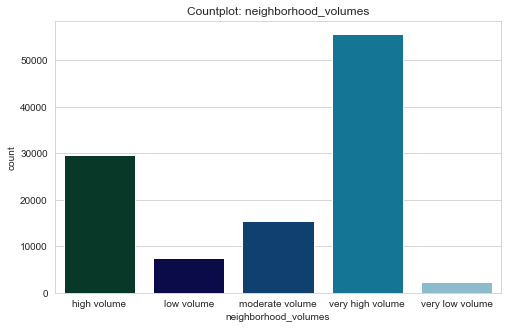

### Describe ###
count               110522
unique                   5
top       very high volume
freq                 55668
Name: neighborhood_volumes, dtype: object

### Value counts ###
very high volume    55668
high volume         29564
moderate volume     15392
low volume           7541
very low volume      2357
Name: neighborhood_volumes, dtype: int64



In [52]:
raw_data["neighborhood_volumes"] = raw_data["neighborhood"].apply(lambda x: neighborhood_count.loc[x, "neighborhood_volumes"]).astype("category")
cat_explore(data=raw_data, var="neighborhood_volumes", l=8, w=5)

#### The quantitative variable (more or less)

In [54]:
print("##### age #####\n")
print(raw_data["age"].describe())

##### age #####

count    110522.000000
mean         37.089041
std          23.110064
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64


In [56]:
# Drop values below zero and equal 115
raw_data = raw_data[(raw_data["age"] >= 0) & (raw_data["age"] != 115)]
print("##### age #####\n")
print("Rows: {}\nColumns: {}\n".format(raw_data.shape[0], raw_data.shape[1]))
print(raw_data["age"].describe())

##### age #####

Rows: 110516
Columns: 15

count    110516.000000
mean         37.085861
std          23.104465
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         102.000000
Name: age, dtype: float64


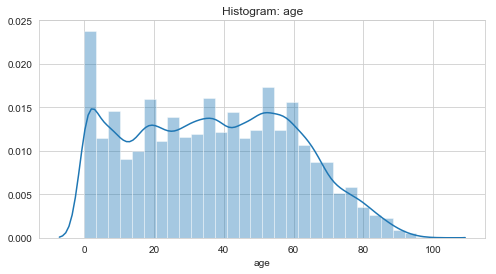

In [57]:
fig = plt.figure(figsize=(8, 4))
sns.distplot(raw_data["age"], bins=30)
plt.title("Histogram: age")
plt.show()

##### age_group #####



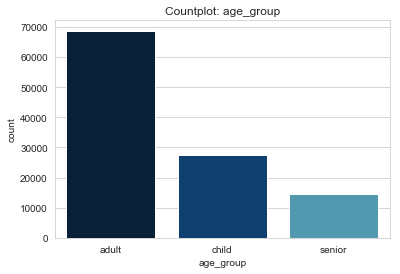

### Describe ###
count     110516
unique         3
top        adult
freq       68742
Name: age_group, dtype: object

### Value counts ###
adult     68742
child     27378
senior    14396
Name: age_group, dtype: int64



In [61]:
# Create age group feature
def age_groups(age):
    if age < 18:
        return "child"
    elif (age >= 18) & (age < 65):
        return "adult"
    else:
        return "senior"

raw_data["age_group"] = raw_data["age"].apply(lambda x: age_groups(x)).astype("category")
cat_explore(data=raw_data, var="age_group")

### Multivariate exploration

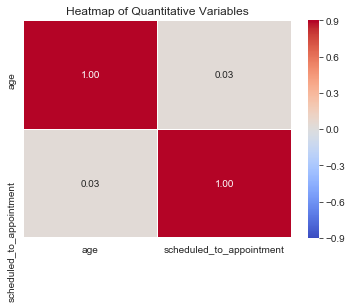

In [65]:
corr_mat = raw_data.corr()
corr_mat

sns.heatmap(data=corr_mat, vmax=0.9, vmin=-0.9, annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
plt.title("Heatmap of Quantitative Variables")
plt.show()

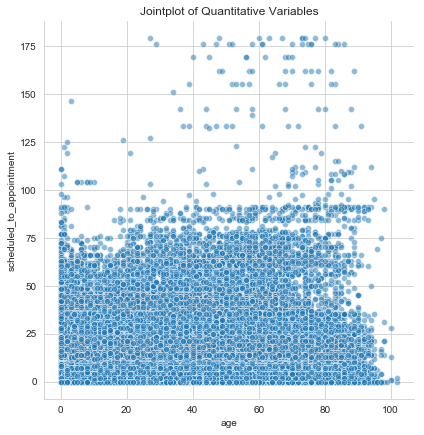

In [76]:
sns.relplot(x="age", y="scheduled_to_appointment", data=raw_data, alpha=0.5, height=6)
plt.title("Jointplot of Quantitative Variables")
plt.show()

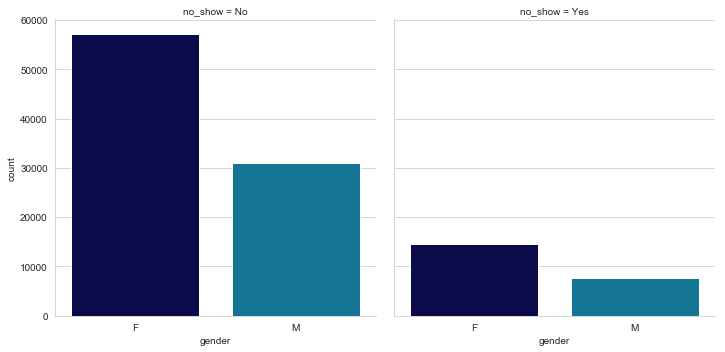

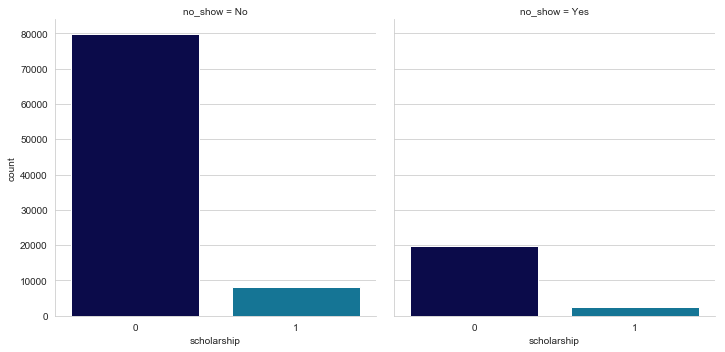

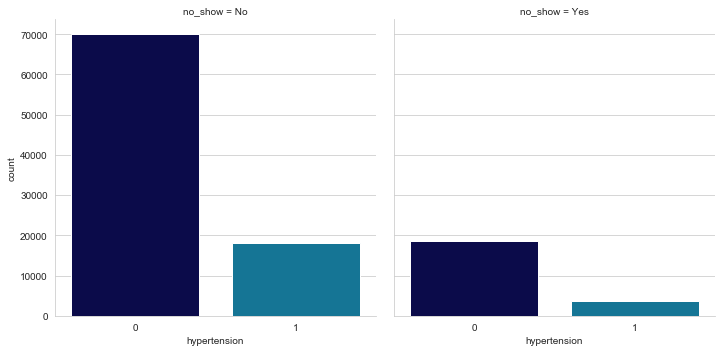

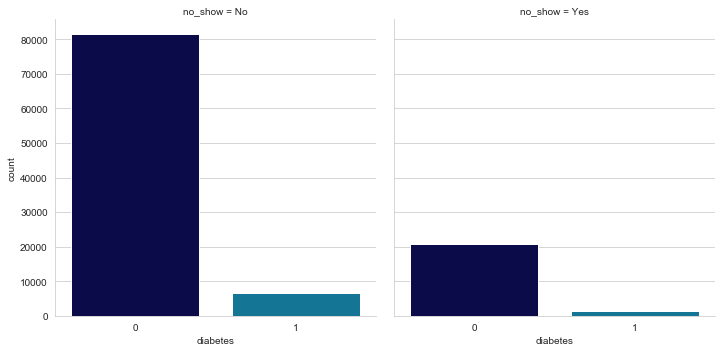

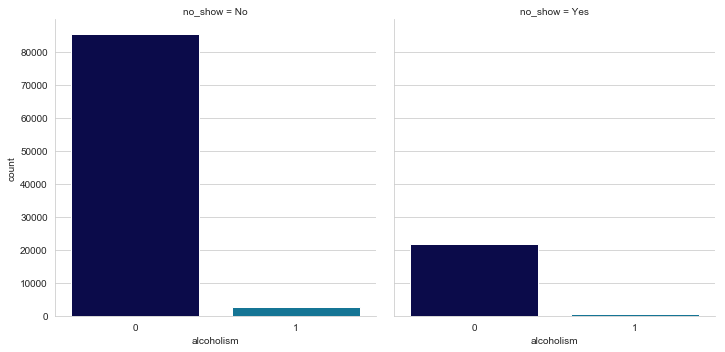

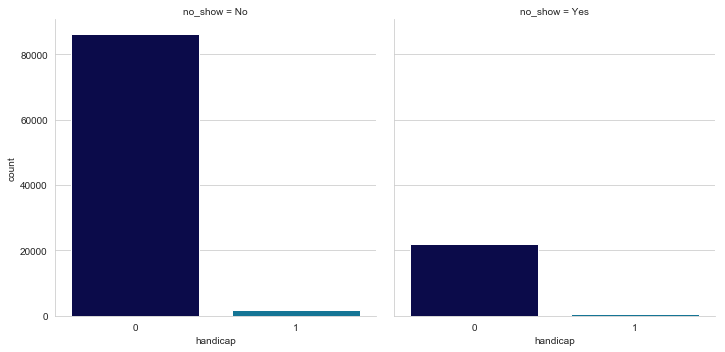

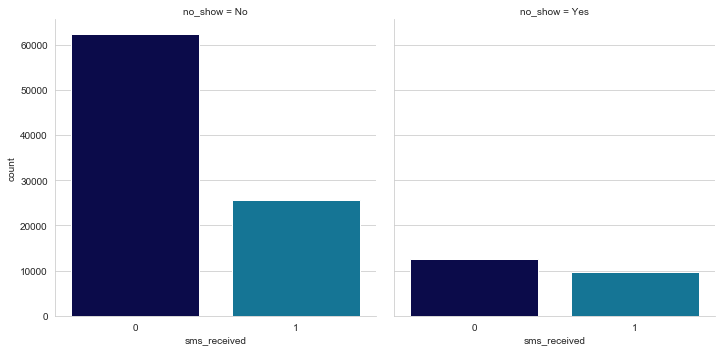

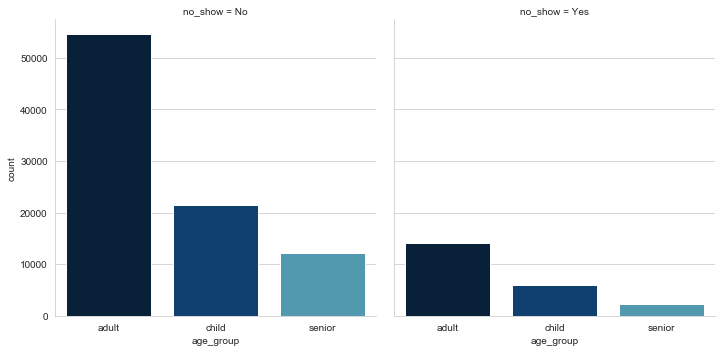

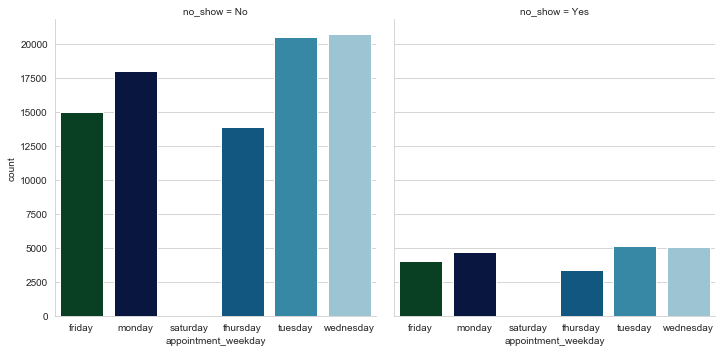

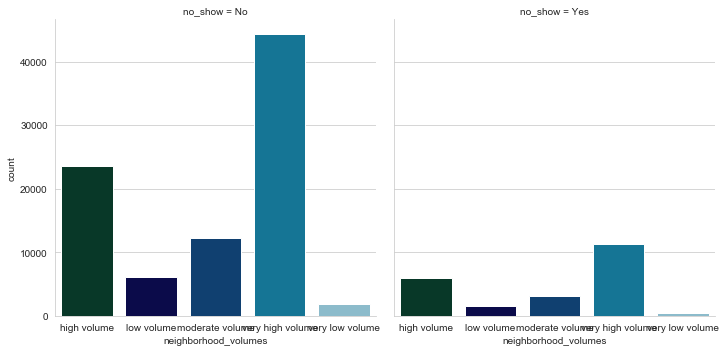

In [96]:
def print_catplots(x_var, col_var, data, kind="count", palette="ocean"):
    sns.catplot(x=x_var, col=col_var, data=data, kind=kind, palette=palette)
    plt.show()

cat_vars = ["gender", "scholarship", "hypertension", "diabetes",
            "alcoholism", "handicap", "sms_received", "age_group",
            "appointment_weekday", "neighborhood_volumes"]

for var in cat_vars:
    print_catplots(x_var=var, col_var="no_show", data=raw_data)

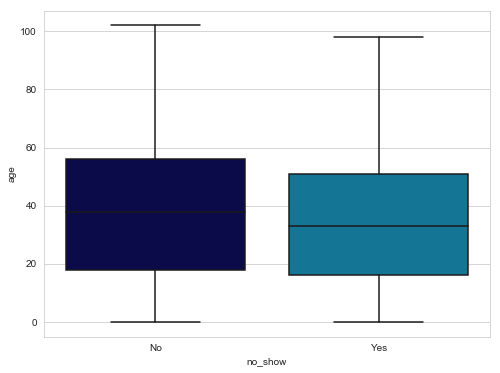

In [98]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="age", data=raw_data, palette="ocean")
plt.show()

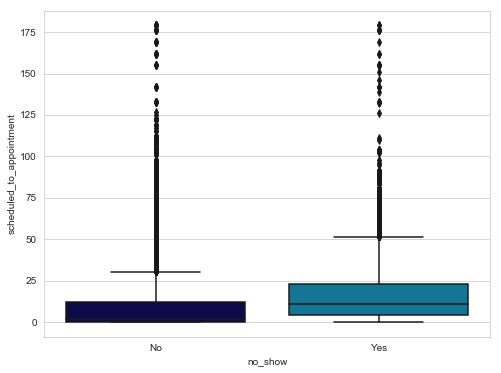

In [99]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="scheduled_to_appointment", data=raw_data, palette="ocean")
plt.show()

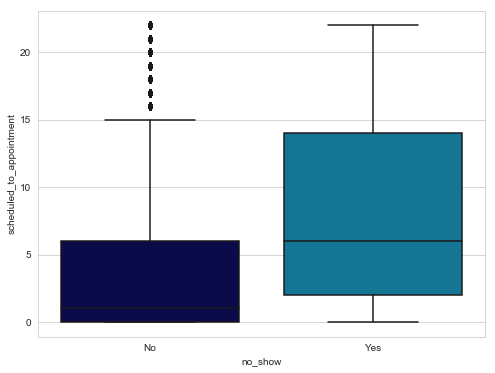

In [100]:
# Remove the upper outliers to get a better view
iqr = raw_data["scheduled_to_appointment"].describe()["75%"] - raw_data["scheduled_to_appointment"].describe()["25%"]
upper_outliers = 1.5 * iqr
sans_outliers = raw_data[raw_data["scheduled_to_appointment"] < upper_outliers]

fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="scheduled_to_appointment", data=sans_outliers, palette="ocean")
plt.show()

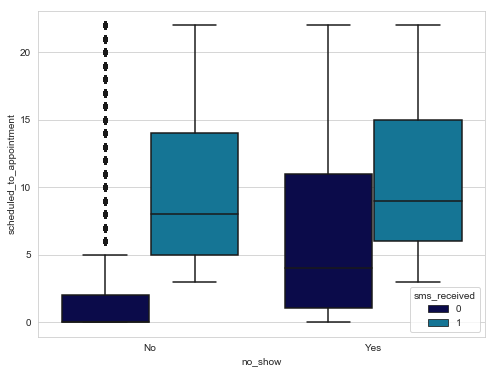

In [101]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="scheduled_to_appointment", hue="sms_received", data=sans_outliers, palette="ocean")
plt.show()

##### same_day_appointment #####



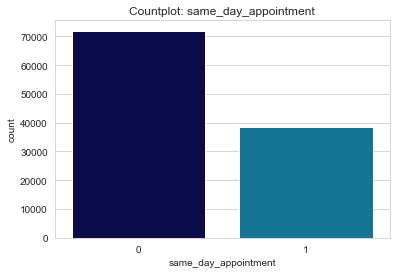

### Describe ###
count     110516
unique         2
top            0
freq       71955
Name: same_day_appointment, dtype: int64

### Value counts ###
0    71955
1    38561
Name: same_day_appointment, dtype: int64



In [102]:
# Create same-day appointment feature
raw_data["same_day_appointment"] = raw_data["scheduled_to_appointment"].apply(lambda x: 1 if x == 0 else 0).astype("category")
cat_explore(data=raw_data, var="same_day_appointment")

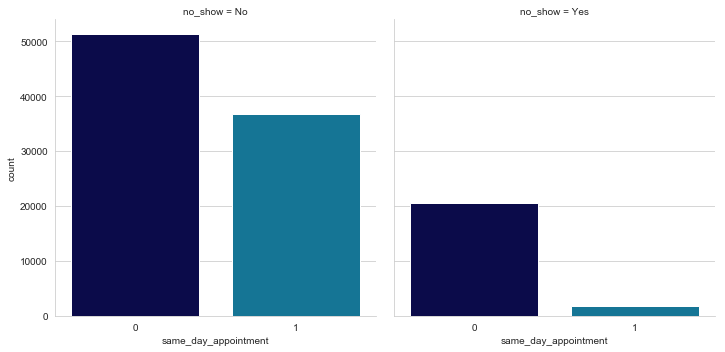

In [104]:
print_catplots(x_var="same_day_appointment", col_var="no_show", data=raw_data)

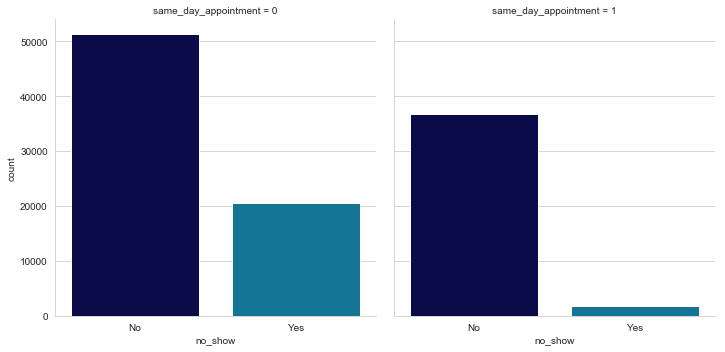

In [105]:
print_catplots(x_var="no_show", col_var="same_day_appointment", data=raw_data)

In [107]:
print("Frequency of No-shows for Same-day-appointments")
print(raw_data[raw_data["same_day_appointment"] == 1]["no_show"].value_counts(normalize=True))

Frequency of No-shows for Same-day-appointments
No     0.953528
Yes    0.046472
Name: no_show, dtype: float64


### Feature selection and sampling

In [145]:
# Split into feature dataframe and target dataframe
#features = raw_data[["scheduled_to_appointment", "same_day_appointment"]]
#target = raw_data["no_show"]

features = raw_data[["gender", "age_group", "scholarship", "hypertension", "diabetes", "alcoholism",
                     "handicap", "sms_received", "neighborhood_volumes", "appointment_weekday",
                    "scheduled_to_appointment", "same_day_appointment"]]
target = raw_data["no_show"]

# Create dummy variables
features = pd.get_dummies(features, drop_first=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110516 entries, 0 to 110526
Data columns (total 20 columns):
scheduled_to_appointment                 110516 non-null int64
gender_M                                 110516 non-null uint8
age_group_child                          110516 non-null uint8
age_group_senior                         110516 non-null uint8
scholarship_1                            110516 non-null uint8
hypertension_1                           110516 non-null uint8
diabetes_1                               110516 non-null uint8
alcoholism_1                             110516 non-null uint8
handicap_1                               110516 non-null uint8
sms_received_1                           110516 non-null uint8
neighborhood_volumes_low volume          110516 non-null uint8
neighborhood_volumes_moderate volume     110516 non-null uint8
neighborhood_volumes_very high volume    110516 non-null uint8
neighborhood_volumes_very low volume     110516 non-null uint8
appoint

#### No sampling

In [146]:
X = features.values
y = np.array(target.values)

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(le.classes_)
print(le.transform(["No", "Yes"]))

['No' 'Yes']
[0 1]


#### Null accuracy rate

In [147]:
y_pred = np.zeros(y.shape[0])
np.mean(y_pred == y)

0.79811972926997

#### Up-sampling

In [148]:
# Up-sample to balance target class
X_upsampled, y_upsampled = resample(X_train[y_train == 1], y_train[y_train == 1], replace=True,
                                   n_samples=X_train[y_train == 0].shape[0])

X_train_up = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_up = np.hstack((y_train[y_train == 0], y_upsampled))

y_pred = np.zeros(y_train_up.shape[0])
np.mean(y_pred == y_train_up)

0.5

#### Down-sampling

In [149]:
# Down-sample to balance target class
X_downsampled, y_downsampled = resample(X_train[y_train == 0], y_train[y_train == 0], replace=True,
                                   n_samples=X_train[y_train == 1].shape[0])

X_train_down = np.vstack((X_train[y_train == 1], X_downsampled))
y_train_down = np.hstack((y_train[y_train == 1], y_downsampled))

y_pred = np.zeros(y_train_down.shape[0])
np.mean(y_pred == y_train_down)

0.5

#### SMOTE

In [150]:
# SMOTE
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

y_pred = np.zeros(y_train_smote.shape[0])
np.mean(y_pred == y_train_smote)

0.5

## Training

In [152]:
# Set up results dictionary
results = {"model": [], "sample_method":[], "mean_train_acc": [], "std_train_acc": [],
           "test_acc": [], "tp": [], "tn": [], "fp": [], "fn": [], "recall": [],
           "precision": [], "f1_score": [], "runtime": []}

# Set-up helper functions
def print_confumat(confumat):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confumat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confumat.shape[0]):
        for j in range(confumat.shape[1]):
            ax.text(x=j, y=i, s=confumat[i, j], va="center", ha="center")
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.grid(None)
    plt.show()

def print_results(model, sample_method, mean_train_acc, std_train_acc, test_acc, rec_score,
                  prec_score, eff_1_score, elapsed_time, confumat):
    print("###### Results ######")
    print("Model: {}\nSampling: {}".format(model, sample_method))
    print("Mean Training Accuracy: {:.3f}".format(mean_train_acc))
    print("Std Training Accuracy: {:.3f}".format(std_train_acc))
    print("Test Accuracy: {:.3f}".format(test_acc))
    print("Recall: {:.3f}".format(rec_score))
    print("Precision: {:.3f}".format(prec_score))
    print("F1 Score: {:.3f}".format(eff_1_score))
    print("Runtime: {:.5f}".format(elapsed_time))
    print_confumat(confumat)

def run_model(model, X_train, y_train, X_test, y_test, result_dict, sample_method="none", cv=10):
    # Run model and store results
    start_time = time.time()
    mod = model
    model_name = str(mod.__class__).split(".")[-1].replace("'>", "")
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    
    scores = cross_val_score(mod, X_train, y_train, cv=cv)
    mean_train_acc = np.mean(scores)
    std_train_acc = np.std(scores)
    test_acc = accuracy_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred)
    eff_1_score = f1_score(y_test, y_pred)
    confumat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confumat.ravel()
    elapsed_time = time.time() - start_time
    
    # Append results to dictionary
    result_dict["model"].append(model_name)
    result_dict["sample_method"].append(sample_method)
    result_dict["mean_train_acc"].append(mean_train_acc)
    result_dict["std_train_acc"].append(std_train_acc)
    result_dict["test_acc"].append(test_acc)
    result_dict["tp"].append(tp)
    result_dict["tn"].append(tn)
    result_dict["fp"].append(fp)
    result_dict["fn"].append(fn)
    result_dict["recall"].append(rec_score)
    result_dict["precision"].append(prec_score)
    result_dict["f1_score"].append(eff_1_score)
    result_dict["runtime"].append(elapsed_time)
    
    # Display results
    print_results(model_name, sample_method, mean_train_acc, std_train_acc, test_acc,
                  rec_score, prec_score, eff_1_score, elapsed_time, confumat)


### Naive Bayes

###### Results ######
Model: BernoulliNB
Sampling: none
Mean Training Accuracy: 0.749
Std Training Accuracy: 0.005
Test Accuracy: 0.747
Recall: 0.193
Precision: 0.303
F1 Score: 0.236
Runtime: 0.84374


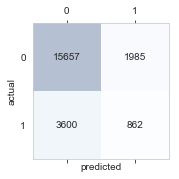

###### Results ######
Model: BernoulliNB
Sampling: up-sampled
Mean Training Accuracy: 0.666
Std Training Accuracy: 0.003
Test Accuracy: 0.528
Recall: 0.908
Precision: 0.288
F1 Score: 0.437
Runtime: 1.29653


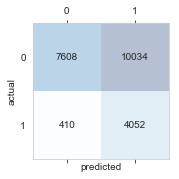

###### Results ######
Model: BernoulliNB
Sampling: down-sampled
Mean Training Accuracy: 0.663
Std Training Accuracy: 0.006
Test Accuracy: 0.528
Recall: 0.906
Precision: 0.287
F1 Score: 0.436
Runtime: 0.35704


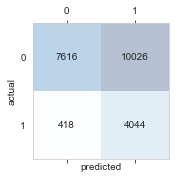

###### Results ######
Model: BernoulliNB
Sampling: smote
Mean Training Accuracy: 0.667
Std Training Accuracy: 0.003
Test Accuracy: 0.524
Recall: 0.916
Precision: 0.287
F1 Score: 0.437
Runtime: 1.25963


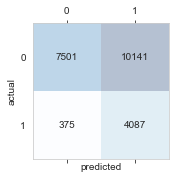

In [153]:
run_model(BernoulliNB(), X_train, y_train, X_test, y_test, results)
run_model(BernoulliNB(), X_train_up, y_train_up, X_test, y_test, results, sample_method="up-sampled")
run_model(BernoulliNB(), X_train_down, y_train_down, X_test, y_test, results, sample_method="down-sampled")
run_model(BernoulliNB(), X_train_smote, y_train_smote, X_test, y_test, results, sample_method="smote")

### K Nearest Neighbors

###### Results ######
Model: KNeighborsClassifier
Sampling: none
Mean Training Accuracy: 0.766
Std Training Accuracy: 0.004
Test Accuracy: 0.768
Recall: 0.177
Precision: 0.353
F1 Score: 0.236
Runtime: 63.12790


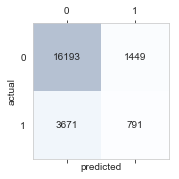

###### Results ######
Model: KNeighborsClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.691
Std Training Accuracy: 0.005
Test Accuracy: 0.668
Recall: 0.518
Precision: 0.309
F1 Score: 0.387
Runtime: 106.48486


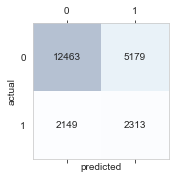

###### Results ######
Model: KNeighborsClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.561
Std Training Accuracy: 0.008
Test Accuracy: 0.442
Recall: 0.742
Precision: 0.228
F1 Score: 0.349
Runtime: 9.84832


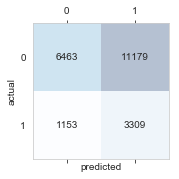

###### Results ######
Model: KNeighborsClassifier
Sampling: smote
Mean Training Accuracy: 0.701
Std Training Accuracy: 0.013
Test Accuracy: 0.689
Recall: 0.459
Precision: 0.315
F1 Score: 0.373
Runtime: 97.86763


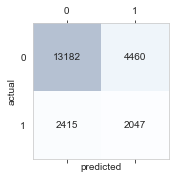

In [154]:
run_model(KNeighborsClassifier(), X_train, y_train, X_test, y_test, results)
run_model(KNeighborsClassifier(), X_train_up, y_train_up, X_test, y_test, results, sample_method="up-sampled")
run_model(KNeighborsClassifier(), X_train_down, y_train_down, X_test, y_test, results, sample_method="down-sampled")
run_model(KNeighborsClassifier(), X_train_smote, y_train_smote, X_test, y_test, results, sample_method="smote")

### Decision Tree

###### Results ######
Model: DecisionTreeClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.000
Precision: 0.500
F1 Score: 0.001
Runtime: 1.34739


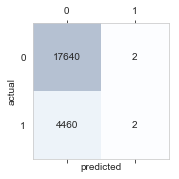

###### Results ######
Model: DecisionTreeClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.670
Std Training Accuracy: 0.003
Test Accuracy: 0.547
Recall: 0.888
Precision: 0.294
F1 Score: 0.442
Runtime: 2.45542


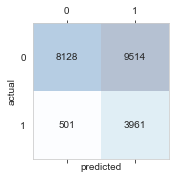

###### Results ######
Model: DecisionTreeClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.668
Std Training Accuracy: 0.006
Test Accuracy: 0.569
Recall: 0.846
Precision: 0.299
F1 Score: 0.442
Runtime: 0.45078


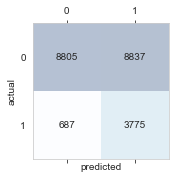

###### Results ######
Model: DecisionTreeClassifier
Sampling: smote
Mean Training Accuracy: 0.685
Std Training Accuracy: 0.016
Test Accuracy: 0.609
Recall: 0.749
Precision: 0.308
F1 Score: 0.436
Runtime: 2.90426


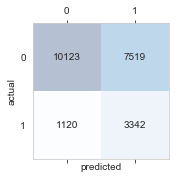

In [155]:
run_model(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test, results)
run_model(DecisionTreeClassifier(max_depth=5), X_train_up, y_train_up,
          X_test, y_test, results, sample_method="up-sampled")
run_model(DecisionTreeClassifier(max_depth=5), X_train_down, y_train_down,
          X_test, y_test, results, sample_method="down-sampled")
run_model(DecisionTreeClassifier(max_depth=5), X_train_smote, y_train_smote,
          X_test, y_test, results, sample_method="smote")

### Random Forest

###### Results ######
Model: RandomForestClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.000
Precision: 0.000
F1 Score: 0.000
Runtime: 15.05297


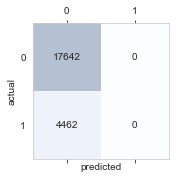

###### Results ######
Model: RandomForestClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.003
Test Accuracy: 0.523
Recall: 0.921
Precision: 0.288
F1 Score: 0.438
Runtime: 25.11673


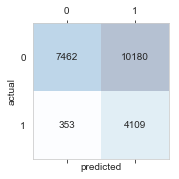

###### Results ######
Model: RandomForestClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.666
Std Training Accuracy: 0.007
Test Accuracy: 0.526
Recall: 0.917
Precision: 0.288
F1 Score: 0.439
Runtime: 5.18412


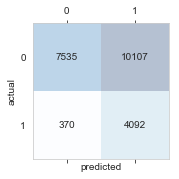

###### Results ######
Model: RandomForestClassifier
Sampling: smote
Mean Training Accuracy: 0.689
Std Training Accuracy: 0.014
Test Accuracy: 0.580
Recall: 0.824
Precision: 0.302
F1 Score: 0.442
Runtime: 26.65481


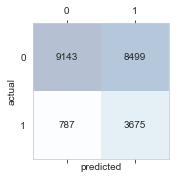

In [156]:
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test, results)
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Logisitic Regression

###### Results ######
Model: LogisticRegression
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.001
Precision: 0.357
F1 Score: 0.002
Runtime: 2.52524


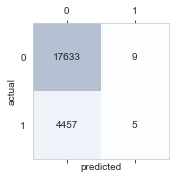

###### Results ######
Model: LogisticRegression
Sampling: up-sampled
Mean Training Accuracy: 0.668
Std Training Accuracy: 0.003
Test Accuracy: 0.553
Recall: 0.875
Precision: 0.295
F1 Score: 0.442
Runtime: 4.44011


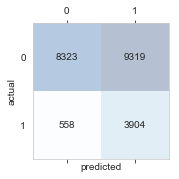

###### Results ######
Model: LogisticRegression
Sampling: down-sampled
Mean Training Accuracy: 0.665
Std Training Accuracy: 0.008
Test Accuracy: 0.551
Recall: 0.877
Precision: 0.294
F1 Score: 0.441
Runtime: 0.96940


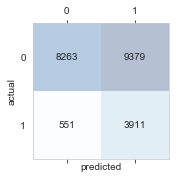

###### Results ######
Model: LogisticRegression
Sampling: smote
Mean Training Accuracy: 0.670
Std Training Accuracy: 0.004
Test Accuracy: 0.565
Recall: 0.852
Precision: 0.298
F1 Score: 0.442
Runtime: 5.71968


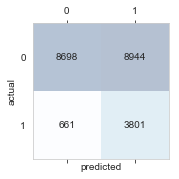

In [157]:
run_model(LogisticRegression(C=1000), X_train, y_train, X_test, y_test, results)
run_model(LogisticRegression(C=1000), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")
run_model(LogisticRegression(C=1000), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")
run_model(LogisticRegression(C=1000), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Ridge Classification

###### Results ######
Model: RidgeClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.001
Precision: 0.273
F1 Score: 0.001
Runtime: 0.67320


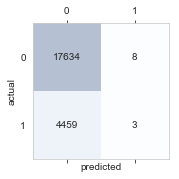

###### Results ######
Model: RidgeClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.668
Std Training Accuracy: 0.003
Test Accuracy: 0.545
Recall: 0.887
Precision: 0.293
F1 Score: 0.441
Runtime: 0.96342


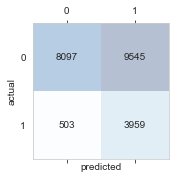

###### Results ######
Model: RidgeClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.666
Std Training Accuracy: 0.007
Test Accuracy: 0.544
Recall: 0.888
Precision: 0.292
F1 Score: 0.440
Runtime: 0.27825


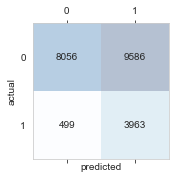

###### Results ######
Model: RidgeClassifier
Sampling: smote
Mean Training Accuracy: 0.670
Std Training Accuracy: 0.003
Test Accuracy: 0.558
Recall: 0.864
Precision: 0.296
F1 Score: 0.441
Runtime: 0.92951


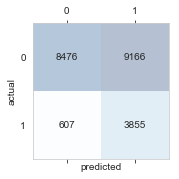

In [158]:
run_model(RidgeClassifier(), X_train, y_train, X_test, y_test, results)
run_model(RidgeClassifier(), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")
run_model(RidgeClassifier(), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")
run_model(RidgeClassifier(), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Lasso Regression

###### Results ######
Model: LogisticRegression
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.001
Precision: 0.357
F1 Score: 0.002
Runtime: 2.52926


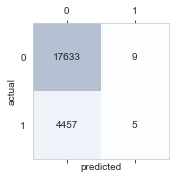

###### Results ######
Model: LogisticRegression
Sampling: up-sampled
Mean Training Accuracy: 0.668
Std Training Accuracy: 0.003
Test Accuracy: 0.553
Recall: 0.875
Precision: 0.295
F1 Score: 0.441
Runtime: 4.14689


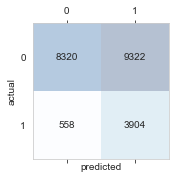

###### Results ######
Model: LogisticRegression
Sampling: down-sampled
Mean Training Accuracy: 0.665
Std Training Accuracy: 0.008
Test Accuracy: 0.550
Recall: 0.877
Precision: 0.294
F1 Score: 0.441
Runtime: 1.07612


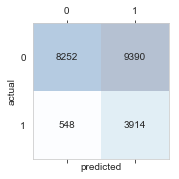

###### Results ######
Model: LogisticRegression
Sampling: smote
Mean Training Accuracy: 0.670
Std Training Accuracy: 0.004
Test Accuracy: 0.566
Recall: 0.852
Precision: 0.298
F1 Score: 0.442
Runtime: 4.67686


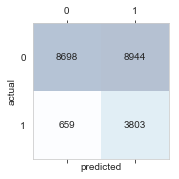

In [159]:
run_model(LogisticRegression(penalty="l1"), X_train, y_train, X_test, y_test, results)
run_model(LogisticRegression(penalty="l1"), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")
run_model(LogisticRegression(penalty="l1"), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")
run_model(LogisticRegression(penalty="l1"), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Support Vector Machines

###### Results ######
Model: SVC
Sampling: none
Mean Training Accuracy: 0.529
Std Training Accuracy: 0.159
Test Accuracy: 0.594
Recall: 0.228
Precision: 0.156
F1 Score: 0.185
Runtime: 5.54698


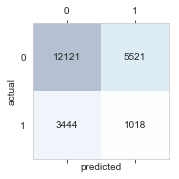

###### Results ######
Model: SVC
Sampling: up-sampled
Mean Training Accuracy: 0.445
Std Training Accuracy: 0.090
Test Accuracy: 0.754
Recall: 0.195
Precision: 0.321
F1 Score: 0.242
Runtime: 7.49164


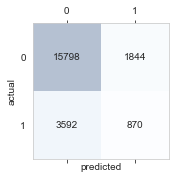

###### Results ######
Model: SVC
Sampling: down-sampled
Mean Training Accuracy: 0.494
Std Training Accuracy: 0.030
Test Accuracy: 0.793
Recall: 0.017
Precision: 0.289
F1 Score: 0.032
Runtime: 1.88295


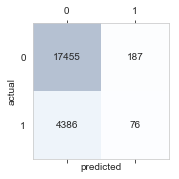

###### Results ######
Model: SVC
Sampling: smote
Mean Training Accuracy: 0.542
Std Training Accuracy: 0.011
Test Accuracy: 0.678
Recall: 0.319
Precision: 0.258
F1 Score: 0.286
Runtime: 7.98549


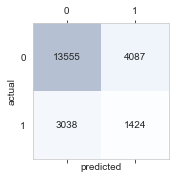

In [160]:
run_model(SVC(max_iter=50), X_train, y_train, X_test, y_test, results)
run_model(SVC(max_iter=50), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")
run_model(SVC(max_iter=50), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")
run_model(SVC(max_iter=50), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Gradient Boosting

###### Results ######
Model: GradientBoostingClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.001
Test Accuracy: 0.798
Recall: 0.005
Precision: 0.561
F1 Score: 0.010
Runtime: 255.92456


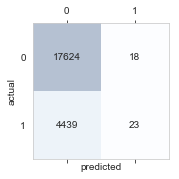

###### Results ######
Model: GradientBoostingClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.673
Std Training Accuracy: 0.003
Test Accuracy: 0.561
Recall: 0.853
Precision: 0.296
F1 Score: 0.440
Runtime: 441.56617


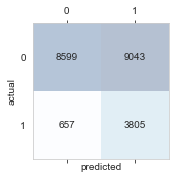

###### Results ######
Model: GradientBoostingClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.007
Test Accuracy: 0.565
Recall: 0.847
Precision: 0.297
F1 Score: 0.440
Runtime: 73.37261


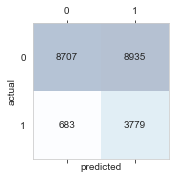

###### Results ######
Model: GradientBoostingClassifier
Sampling: smote
Mean Training Accuracy: 0.726
Std Training Accuracy: 0.056
Test Accuracy: 0.660
Recall: 0.602
Precision: 0.319
F1 Score: 0.417
Runtime: 504.31066


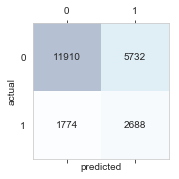

In [161]:
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train, y_train, X_test, y_test,
          results)
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train_up, y_train_up,
          X_test, y_test, results, sample_method="up-sampled")
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train_down, y_train_down,
          X_test, y_test, results, sample_method="down-sampled")
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train_smote, y_train_smote,
          X_test, y_test, results, sample_method="smote")

### XGBoost

###### Results ######
Model: XGBClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.003
Precision: 0.700
F1 Score: 0.006
Runtime: 49.01034


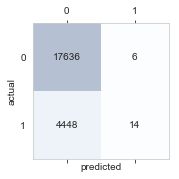

###### Results ######
Model: XGBClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.673
Std Training Accuracy: 0.004
Test Accuracy: 0.559
Recall: 0.859
Precision: 0.296
F1 Score: 0.440
Runtime: 81.22184


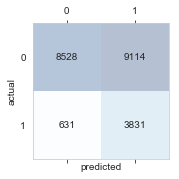

###### Results ######
Model: XGBClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.670
Std Training Accuracy: 0.007
Test Accuracy: 0.563
Recall: 0.851
Precision: 0.297
F1 Score: 0.440
Runtime: 19.75933


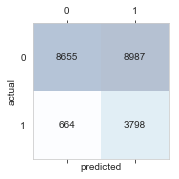

###### Results ######
Model: XGBClassifier
Sampling: smote
Mean Training Accuracy: 0.714
Std Training Accuracy: 0.036
Test Accuracy: 0.631
Recall: 0.701
Precision: 0.314
F1 Score: 0.434
Runtime: 82.45944


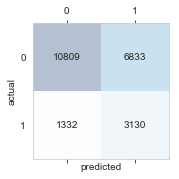

In [162]:
run_model(XGBClassifier(), X_train, y_train, X_test, y_test, results)
run_model(XGBClassifier(), X_train_up, y_train_up, X_test, y_test, results, sample_method="up-sampled")
run_model(XGBClassifier(), X_train_down, y_train_down, X_test, y_test, results, sample_method="down-sampled")
run_model(XGBClassifier(), X_train_smote, y_train_smote, X_test, y_test, results, sample_method="smote")

In [163]:
results_df = pd.DataFrame(results)
results_df = results_df[["model", "sample_method", "mean_train_acc", "std_train_acc", "test_acc",
"precision", "recall", "f1_score", "tp", "tn", "fp", "fn", "runtime"]]
results_df

,model,sample_method,mean_train_acc,std_train_acc,test_acc,precision,recall,f1_score,tp,tn,fp,fn,runtime
0,BernoulliNB,none,0.748722,0.004995,0.747331,0.302775,0.193187,0.235874,862,15657,1985,3600,0.843741
1,BernoulliNB,up-sampled,0.665965,0.002927,0.527506,0.287662,0.908113,0.436920,4052,7608,10034,410,1.296529
2,BernoulliNB,down-sampled,0.663203,0.006035,0.527506,0.287420,0.906320,0.436434,4044,7616,10026,418,0.357043
3,BernoulliNB,smote,0.666589,0.003334,0.524249,0.287250,0.915957,0.437346,4087,7501,10141,375,1.259627
4,KNeighborsClassifier,none,0.766084,0.004070,0.768368,0.353125,0.177275,0.236049,791,16193,1449,3671,63.127900
5,KNeighborsClassifier,up-sampled,0.690631,0.004629,0.668476,0.308729,0.518377,0.386983,2313,12463,5179,2149,106.484860
6,KNeighborsClassifier,down-sampled,0.560872,0.008489,0.442092,0.228396,0.741596,0.349235,3309,6463,11179,1153,9.848316
7,KNeighborsClassifier,smote,0.700977,0.012976,0.688970,0.314584,0.458763,0.373234,2047,13182,4460,2415,97.867633
8,DecisionTreeClassifier,none,0.798184,0.000149,0.798136,0.500000,0.000448,0.000896,2,17640,2,4460,1.347392
9,DecisionTreeClassifier,up-sampled,0.669891,0.003180,0.546915,0.293952,0.887719,0.441657,3961,8128,9514,501,2.455423


In [167]:
results_df.groupby("sample_method").mean()

,mean_train_acc,std_train_acc,test_acc,precision,recall,f1_score,tp,tn,fp,fn,runtime
sample_method,,,,,,,,,,,
down-sampled,0.638691,0.009347,0.563102,0.286757,0.776804,0.390036,3466.1,8980.7,8661.3,995.9,11.317892
none,0.763049,0.016938,0.769707,0.355957,0.061026,0.068016,272.3,16741.3,900.7,4189.7,39.658157
smote,0.673296,0.016101,0.605985,0.299585,0.713850,0.415024,3185.2,10209.5,7432.5,1276.8,73.476798
up-sampled,0.649085,0.011998,0.579235,0.297416,0.777857,0.414976,3470.8,9332.6,8309.4,991.2,67.518362


In [174]:
results_df[(results_df["sample_method"] == "smote")].sort_values("precision", ascending=False).head(n=3)

,model,sample_method,mean_train_acc,std_train_acc,test_acc,precision,recall,f1_score,tp,tn,fp,fn,runtime
35,GradientBoostingClassifier,smote,0.725504,0.056230,0.660423,0.319240,0.602420,0.417327,2688,11910,5732,1774,504.310657
7,KNeighborsClassifier,smote,0.700977,0.012976,0.688970,0.314584,0.458763,0.373234,2047,13182,4460,2415,97.867633
39,XGBClassifier,smote,0.713825,0.035954,0.630610,0.314162,0.701479,0.433969,3130,10809,6833,1332,82.459444


### Tune GradientBoosting\SMOTE

In [180]:
gbc = GradientBoostingClassifier()
param_grid = {"n_estimators": [50, 100, 250, 500, 1000]}

gs_gbc = GridSearchCV(estimator=gbc,
                    param_grid = param_grid,
                    scoring="accuracy",
                    cv=5,
                    n_jobs=-1)
gs_gbc.fit(X_train_smote, y_train_smote)

print(gs_gbc.best_score_)
print(gs_gbc.best_params_)

0.7311480520952908
{'n_estimators': 1000}


### Tune KNeighborsClassifier\SMOTE

In [181]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": [1, 5, 10, 15, 20, 25, 30],
             "weights": ["uniform", "distance"]}

gs_knn = GridSearchCV(estimator=knn,
                    param_grid = param_grid,
                    scoring="accuracy",
                    cv=5,
                    n_jobs=-1)
gs_knn.fit(X_train_smote, y_train_smote)

print(gs_knn.best_score_)
print(gs_knn.best_params_)

0.7266060116491646
{'n_neighbors': 30, 'weights': 'distance'}


### Tune XGBClassifier\SMOTE

In [182]:
xgb = XGBClassifier()
param_grid = {"max_depth": [1, 5, 10],
             "n_estimators": [100, 250, 500]}

gs_xgb = GridSearchCV(estimator=xgb,
                    param_grid = param_grid,
                    scoring="accuracy",
                    cv=5,
                    n_jobs=-1)
gs_xgb.fit(X_train_smote, y_train_smote)

print(gs_xgb.best_score_)
print(gs_xgb.best_params_)

0.7552683417655145
{'max_depth': 10, 'n_estimators': 500}


### Run tuned models

In [183]:
# Set up results dictionary
results_2 = {"model": [], "sample_method":[], "mean_train_acc": [], "std_train_acc": [],
           "test_acc": [], "tp": [], "tn": [], "fp": [], "fn": [], "recall": [],
           "precision": [], "f1_score": [], "runtime": []}

###### Results ######
Model: GradientBoostingClassifier
Sampling: smote
Mean Training Accuracy: 0.747
Std Training Accuracy: 0.071
Test Accuracy: 0.688
Recall: 0.506
Precision: 0.325
F1 Score: 0.396
Runtime: 2968.64009


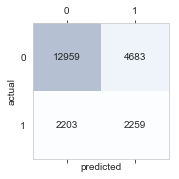

###### Results ######
Model: KNeighborsClassifier
Sampling: smote
Mean Training Accuracy: 0.727
Std Training Accuracy: 0.040
Test Accuracy: 0.695
Recall: 0.449
Precision: 0.318
F1 Score: 0.373
Runtime: 162.54548


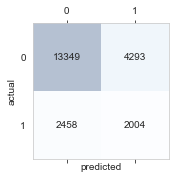

###### Results ######
Model: XGBClassifier
Sampling: smote
Mean Training Accuracy: 0.759
Std Training Accuracy: 0.070
Test Accuracy: 0.689
Recall: 0.483
Precision: 0.320
F1 Score: 0.385
Runtime: 1239.36180


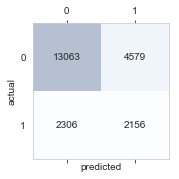

In [184]:
run_model(GradientBoostingClassifier(n_estimators=1000, max_depth=5, loss="deviance"), X_train_smote, y_train_smote,
          X_test, y_test, results_2, sample_method="smote")
run_model(KNeighborsClassifier(n_neighbors=30, weights="distance"), X_train_smote, y_train_smote,
          X_test, y_test, results_2, sample_method="smote")
run_model(XGBClassifier(max_depth=10, n_estimators=500), X_train_smote, y_train_smote,
          X_test, y_test, results_2, sample_method="smote")

In [185]:
results_df_2 = pd.DataFrame(results_2)
results_df_2 = results_df_2[["model", "sample_method", "mean_train_acc", "std_train_acc", "test_acc",
"precision", "recall", "f1_score", "tp", "tn", "fp", "fn", "runtime"]]
results_df_2

,model,sample_method,mean_train_acc,std_train_acc,test_acc,precision,recall,f1_score,tp,tn,fp,fn,runtime
0,GradientBoostingClassifier,smote,0.746621,0.070713,0.688473,0.325411,0.506275,0.396177,2259,12959,4683,2203,2968.640093
1,KNeighborsClassifier,smote,0.726970,0.040052,0.694580,0.318247,0.449126,0.372525,2004,13349,4293,2458,162.545483
2,XGBClassifier,smote,0.758653,0.069741,0.688518,0.320119,0.483191,0.385103,2156,13063,4579,2306,1239.361799


### Voting Classifier

In [188]:
# Set up results dictionary
results_3 = {"model": [], "sample_method":[], "mean_train_acc": [], "std_train_acc": [],
           "test_acc": [], "tp": [], "tn": [], "fp": [], "fn": [], "recall": [],
           "precision": [], "f1_score": [], "runtime": []}

###### Results ######
Model: VotingClassifier
Sampling: smote
Mean Training Accuracy: 0.759
Std Training Accuracy: 0.070
Test Accuracy: 0.691
Recall: 0.485
Precision: 0.323
F1 Score: 0.388
Runtime: 3814.45969


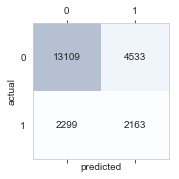

In [189]:
clf1 = GradientBoostingClassifier(n_estimators=1000, max_depth=5, loss="deviance")
clf2 = KNeighborsClassifier(n_neighbors=30, weights="distance")
clf3 = XGBClassifier(max_depth=10, n_estimators=500)

run_model(VotingClassifier(estimators=[("knn", clf1), ("rf", clf2), ("las", clf3)], voting='hard'),
          X_train_smote, y_train_smote, X_test, y_test, results_3, sample_method="smote")

In [190]:
results_df_3 = pd.DataFrame(results_3)
results_df_3 = results_df_3[["model", "sample_method", "mean_train_acc", "std_train_acc", "test_acc",
"precision", "recall", "f1_score", "tp", "tn", "fp", "fn", "runtime"]]
results_df_3

,model,sample_method,mean_train_acc,std_train_acc,test_acc,precision,recall,f1_score,tp,tn,fp,fn,runtime
0,VotingClassifier,smote,0.758603,0.06956,0.690916,0.323029,0.48476,0.387704,2163,13109,4533,2299,3814.45969
